## Лабораторная работа 3. PySpark.

## Группа: РИМ-211060

### ФИО студентов:
#### Степаненко Дмитрий Владимирович
#### Стойчин Красимир Людмилов

## 0. Цель работы: выполнить анализ текста для одного из наборов данных используя технологии машинного обучения. Рассмотреть возможности мультиклассовой классификации текстов с MLlib и PySpark.

## 6. Предложите свой набор данных для анализа. Модель классификации преступлений с использованием Pyspark

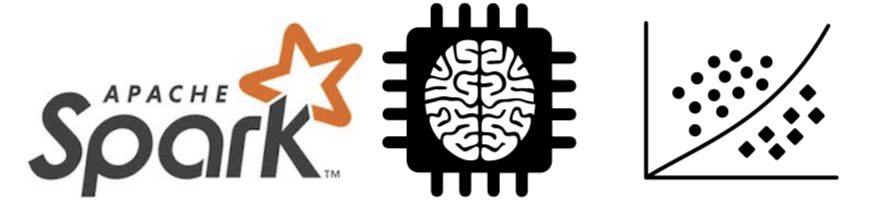

In [2]:
from IPython.display import Image
Image('spark_ml.png')

### 1. Область применения:
- нас интересует система, которая могла бы классифицировать описание преступления по разным категориям. Мы хотим создать систему, которая могла бы автоматически относить описанное преступление к категории, которая могла бы помочь правоохранительным органам назначить правильных сотрудников для совершения преступления или могла бы автоматически назначать сотрудников для совершения преступления на основе классификации;
- мы используем данные Kaggle о преступности в Сан-Франциско. Наша задача заключается в обучении модели на основе 39 заранее определенных категорий, тестировании точности модели и внедрении ее в производство. Учитывая новое описание преступления, система должна отнести его к одной из 39 категорий;
- чтобы решить эту проблему, мы будем использовать различные методы извлечения признаков наряду с различными контролируемыми алгоритмами машинного обучения в Pyspark;
- это многоклассовая проблема классификации текста.

### 2. Установка Spark и загрузка необходимых библиотеки:

In [3]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("clipper-pyspark").getOrCreate()

sc = spark.sparkContext

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(60)

### 3. Извлечение данных:

In [6]:
#Read the data into spark datafrome
from pyspark.sql.functions import col, lower
df = spark.read.format('csv')\
          .option('header','true')\
          .option('inferSchema', 'true')\
          .option('timestamp', 'true')\
          .load('train.csv')

data = df.select(lower(col('Category')),lower(col('Descript')))\
        .withColumnRenamed('lower(Category)','Category')\
        .withColumnRenamed('lower(Descript)', 'Description')
data.cache()
print('Структура потока данных')
print('----------------------------------')
print(data.printSchema())
print(' ')
print('Предварительный просмотр потока данных')
print(data.show(10))
print(' ')
print('----------------------------------')
print('Общее количество строк', df.count())

Структура потока данных
----------------------------------
root
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)

None
 
Предварительный просмотр потока данных
+--------------+--------------------+
|      Category|         Description|
+--------------+--------------------+
|      warrants|      warrant arrest|
|other offenses|traffic violation...|
|other offenses|traffic violation...|
| larceny/theft|grand theft from ...|
| larceny/theft|grand theft from ...|
| larceny/theft|grand theft from ...|
| vehicle theft|   stolen automobile|
| vehicle theft|   stolen automobile|
| larceny/theft|grand theft from ...|
| larceny/theft|grand theft from ...|
+--------------+--------------------+
only showing top 10 rows

None
 
----------------------------------
Общее количество строк 878049


#### Чтобы ознакомиться с набором данных, нужно просмотреть top-список категорий и описаний преступлений.

In [7]:
def top_n_list(df,var, N):
    '''
    Эта функция определяет top-N номеров списка
    '''
    print("Общее количество уникальных значений"+' '+var+''+':'+' '+str(df.select(var).distinct().count()))
    print(' ')
    print('Top'+'-'+str(N)+' '+'Crime'+' '+var)
    df.groupBy(var).count().withColumnRenamed('count','totalValue')\
    .orderBy(col('totalValue').desc()).show(N)
    
    
top_n_list(data, 'Category',10)
print(' ')
print(' ')
top_n_list(data,'Description',10)

Общее количество уникальных значений Category: 39
 
Top-10 Crime Category
+--------------+----------+
|      Category|totalValue|
+--------------+----------+
| larceny/theft|    174900|
|other offenses|    126182|
|  non-criminal|     92304|
|       assault|     76876|
| drug/narcotic|     53971|
| vehicle theft|     53781|
|     vandalism|     44725|
|      warrants|     42214|
|      burglary|     36755|
|suspicious occ|     31414|
+--------------+----------+
only showing top 10 rows

 
 
Общее количество уникальных значений Description: 879
 
Top-10 Crime Description
+--------------------+----------+
|         Description|totalValue|
+--------------------+----------+
|grand theft from ...|     60022|
|       lost property|     31729|
|             battery|     27441|
|   stolen automobile|     26897|
|drivers license, ...|     26839|
|      warrant arrest|     23754|
|suspicious occurr...|     21891|
|aided case, menta...|     21497|
|petty theft from ...|     19771|
|malicious misc

#### Особенностью категории будет наша метка (многоклассовая).

In [8]:
data.select('Category').distinct().count()

39

### 4. Разделим набор данных на обучающий и тестовый:

In [9]:
training, test = data.randomSplit([0.7,0.3], seed=60)
#trainingSet.cache()
print("Количество обучающих наборов данных:", training.count())
print("Количество тестовых наборов данных:", test.count())

Количество обучающих наборов данных: 614457
Количество тестовых наборов данных: 263592


### 5. Определим структуру для построения:
Процесс очистки набора данных включает в себя:
- Определим функцию токенизации с помощью RegexTokenizer;
- Определим функцию удаления остановок с помощью StopWordsRemover;
- Определим функцию bag of words для переменной Descript с помощью CountVectorizer;
- Определим функцию для кодирования значений переменной категории с помощью StringIndexes;
- Определим конвейер для вызова этих функций.

In [10]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF, Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes 

#----------------Define tokenizer with regextokenizer()------------------
regex_tokenizer = RegexTokenizer(pattern='\\W')\
                  .setInputCol("Description")\
                  .setOutputCol("tokens")

#----------------Define stopwords with stopwordsremover()---------------------
extra_stopwords = ['http','amp','rt','t','c','the']
stopwords_remover = StopWordsRemover()\
                    .setInputCol('tokens')\
                    .setOutputCol('filtered_words')\
                    .setStopWords(extra_stopwords)
                    

#----------Define bags of words using countVectorizer()---------------------------
count_vectors = CountVectorizer(vocabSize=10000, minDF=5)\
               .setInputCol("filtered_words")\
               .setOutputCol("features")


#-----------Using TF-IDF to vectorise features instead of countVectoriser-----------------
hashingTf = HashingTF(numFeatures=10000)\
            .setInputCol("filtered_words")\
            .setOutputCol("raw_features")
            
#Use minDocFreq to remove sparse terms
idf = IDF(minDocFreq=5)\
        .setInputCol("raw_features")\
        .setOutputCol("features")

#---------------Define bag of words using Word2Vec---------------------------
word2Vec = Word2Vec(vectorSize=1000, minCount=0)\
           .setInputCol("filtered_words")\
           .setOutputCol("features")

#-----------Encode the Category variable into label using StringIndexer-----------
label_string_idx = StringIndexer()\
                  .setInputCol("Category")\
                  .setOutputCol("label")

#-----------Define classifier structure for logistic Regression--------------
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

#---------Define classifier structure for Naive Bayes----------
nb = NaiveBayes(smoothing=1)

def metrics_ev(labels, metrics):
    '''
    List of all performance metrics
    '''
    # Confusion matrix
    print("---------Confusion matrix-----------------")
    print(metrics.confusionMatrix)
    print(' ')    
    # Overall statistics
    print('----------Overall statistics-----------')
    print("Precision = %s" %  metrics.precision())
    print("Recall = %s" %  metrics.recall())
    print("F1 Score = %s" % metrics.fMeasure())
    print(' ')
    # Statistics by class
    print('----------Statistics by class----------')
    for label in sorted(labels):
       print("Class %s precision = %s" % (label, metrics.precision(label)))
       print("Class %s recall = %s" % (label, metrics.recall(label)))
       print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print(' ')
    # Weighted stats
    print('----------Weighted stats----------------')
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

### 6. Построим мультиклассификацию:
Этапы, необходимые для выполнения мультиклассификации, включают:
- Обучение модели и оценка;
- Построение базовой модели - логистическая регрессия с использованием функций CountVectorizer;
- Построение вторичной модели = наивный Байес + логистическая регрессия, наивный Байес с использованием функций TF-IDF, логистическая регрессия и наивный байесовский подход с использованием word2Vec.


##### Базовая модель. Применим логистическую регрессию с использованием векторных функций подсчета.

Построим модель для прогнозирования и оценки тестовых наборов с использованием логистической регрессии, используя набор данных, который мы преобразовали с помощью векторов подсчета. И мы увидим топ-10 прогнозов с наибольшей вероятностью из нашей модели, точности и других показателей для оценки нашей модели.

In [12]:
pipeline_cv_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, lr])
model_cv_lr = pipeline_cv_lr.fit(training)
predictions_cv_lr = model_cv_lr.transform(test)

In [13]:
print('-----------------------------Проверка Top-5 прогнозов----------------------------------')
print(' ')
predictions_cv_lr.select('Description','Category',"probability","label","prediction")\
                                        .orderBy("probability", ascending=False)\
                                        .show(n=5, truncate=30)

-----------------------------Проверка Top-5 прогнозов----------------------------------
 
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382583,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382583,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382583,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382583,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382583,0.02156...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows



In [14]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
evaluator_cv_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_lr)
print(' ')
print('------------------------------Accuracy (точность)----------------------------------')
print(' ')
print('                       accuracy:{}:'.format(evaluator_cv_lr))

 
------------------------------Accuracy (точность)----------------------------------
 
                       accuracy:0.9723579882349168:


##### Вторичная модель. Применим наивные байесовские методы с помощью векторных объектов Count.

Наивные байесовские классификаторы - это семейство простых вероятностных классификаторов, основанных на применении теоремы Байеса с сильными (наивными) предположениями о независимости между признаками. В spark.ml реализация в настоящее время поддерживает как многочленный наивный Байес, так и наивный Байес Бернулли.

In [15]:
### Secondary model using NaiveBayes
pipeline_cv_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, nb])
model_cv_nb = pipeline_cv_nb.fit(training)
predictions_cv_nb = model_cv_nb.transform(test)

In [16]:
evaluator_cv_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_nb)
print(' ')
print('--------------------------Accuracy (точность)-----------------------------')
print(' ')
print('                      accuracy:{}:'.format(evaluator_cv_nb))

 
--------------------------Accuracy (точность)-----------------------------
 
                      accuracy:0.9935325400900984:


##### Дополнительно. Применим логистическую регрессию, используя TF-IDF-меру.

In [17]:
pipeline_idf_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,hashingTf, idf, label_string_idx, lr])
model_idf_lr = pipeline_idf_lr.fit(training)
predictions_idf_lr = model_idf_lr.transform(test)

In [18]:
print('-----------------------------Проверка Top-5 прогнозов----------------------------------')
print(' ')
predictions_idf_lr.select('Description','Category',"probability","label","prediction")\
                                        .orderBy("probability", ascending=False)\
                                        .show(n=5, truncate=30)

-----------------------------Проверка Top-5 прогнозов----------------------------------
 
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|theft, bicycle, <$50, no se...|larceny/theft|[0.884183475209166,0.019526...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.884183475209166,0.019526...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.884183475209166,0.019526...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.884183475209166,0.019526...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.884183475209166,0.019526...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows



In [19]:
evaluator_idf_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_idf_lr)
print(' ')
print('-------------------------------Accuracy (точность)---------------------------------')
print(' ')
print('                        accuracy:{}:'.format(evaluator_idf_lr))

 
-------------------------------Accuracy (точность)---------------------------------
 
                        accuracy:0.972293366901647:


##### Дополнительно. Применим наивный Байесовский алгоритм, используя TF-IDF-меру.

In [20]:
pipeline_idf_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover,hashingTf, idf, label_string_idx, nb])
model_idf_nb = pipeline_idf_nb.fit(training)
predictions_idf_nb = model_idf_nb.transform(test)

In [21]:
evaluator_idf_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_idf_nb)
print(' ')
print('-----------------------------Accuracy (точность)-----------------------------')
print(' ')
print('                          accuracy:{}:'.format(evaluator_idf_nb))

 
-----------------------------Accuracy (точность)-----------------------------
 
                          accuracy:0.9949302190940209:


### Результаты:

#### В таблице ниже приведена точность моделей, сгенерированных различными методами извлечения.

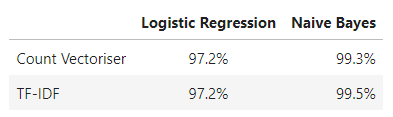

In [22]:
Image('table.png')

#### Как можно увидеть, TF-IDF-мера оказывается лучшим векторизатором для этого набора данных, в то время как наивный Байесовский алгоритм оказывается лучшим алгоритмом для анализа текста, чем логистическая регрессия.